In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(1000, 5, tau=17, seed=0)
Mglass2 = MackeyGlassDataset(10000, 2, tau=20, seed=0)

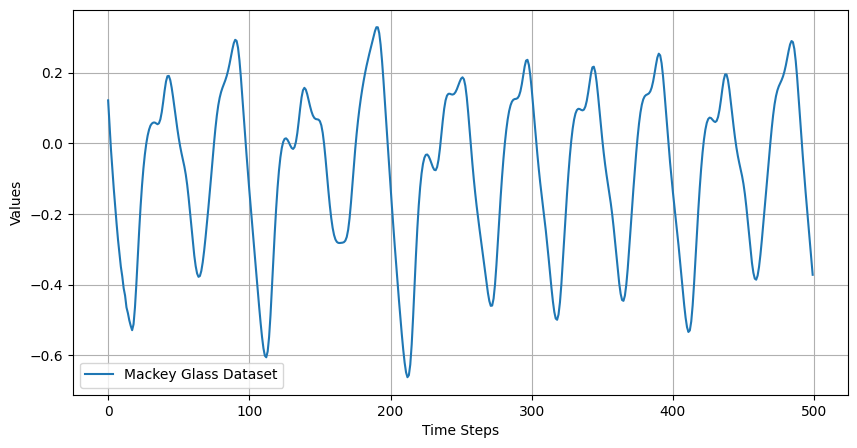

In [3]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.figure(figsize=(10, 5))
plt.plot(dataset[:500], label='Mackey Glass Dataset')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


CPU is available


# ESN 

In [5]:
from Models.Reservoir import Reservoir


In [6]:
Res = Reservoir(input_dim=1, reservoir_dim=300, output_dim=1, 
          spectral_radius=0.95, leak_rate=0.3)

Max Eigenvalue After Scaling: tensor(2.3685)


In [7]:
eigenvalues, _ = torch.linalg.eig(Res.W)  
λ_max = torch.max(torch.abs(eigenvalues))  
print(f"Actual λ_max after scaling: {λ_max.item()} (should match spectral radius {Res.spectral_radius})")


AttributeError: 'Reservoir' object has no attribute 'spectral_radius'

In [ ]:
# Generate synthetic data
time = torch.linspace(0, 10, 1000)
data = torch.sin(time).unsqueeze(1)  # (1000, 1)

# Normalize data to [-1, 1]
data = (data - data.min()) / (data.max() - data.min()) * 2 - 1

# Split into train and test
train_data, test_data = data[:800], data[800:]

# Initialize ESN
Res = Reservoir(input_dim=1, reservoir_dim=300, output_dim=1, 
          spectral_radius=0.95, leak_rate=0.3)

# Train the readout
Res.train_readout(train_data, train_data)

# Warm up reservoir with last 50 points of training data
predictions = Res.predict(train_data[-1:], steps=100)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(torch.cat([train_data[-50:], test_data[:100]]).numpy(), label='True')
plt.plot(range(50, 150), predictions.numpy(), '--', label='Predicted')
plt.axvline(x=50, color='r', linestyle=':', label='Prediction Start')
plt.legend()
plt.show()


plt.plot([state.norm().item() for state in Res.reservoir_states])
plt.xlabel("Timestep")
plt.ylabel("State Norm")
plt.title("Reservoir State Evolution")
plt.show()

Max Eigenvalue After Scaling: tensor(2.2001)


NameError: name 'data' is not defined